In [2]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from surprise import Reader
from surprise import Dataset
from surprise import KNNBasic, SVD, SVDpp
from surprise.model_selection import train_test_split
from surprise.model_selection import cross_validate
from surprise import accuracy

In [3]:
from data_utils import generate_ground_truth_matrix, ground_truth_matrix_to_dataset, to_dataframe, generate_test_dataframe, naive_propensity_estimation, masked_nb_propensity_estimation, mlp_propensity_estimation
from algo import PropensitySVD

# Visualize the effect of selection bias

In [4]:
# Plot P against R (flattened)

def P_R_train(beta):
    truth = generate_ground_truth_matrix(
        (1000, 1000), environment='ml-100k-v1')
    users, items, ratings, P, R, R_no_noise = ground_truth_matrix_to_dataset(
        truth, quantization='onetofive', bias='full underlying', beta=beta, sample_prob=0.1)
    return P, R

beta = np.linspace(0, 2.5, 6)
results = [P_R_train(i) for i in beta]     

Loading model from /Users/fengyuli/opt/anaconda3/envs/rec/lib/python3.10/site-packages/reclab/environments/../../models/ml-100k/fm_model.npz trained via:
{"num_user_features": 0, "num_item_features": 0, "num_rating_features": 0, "max_num_users": 943, "max_num_items": 1682, "method": "sgd", "use_global_bias": true, "use_one_way": true, "num_two_way_factors": 8, "learning_rate": 0.005, "bias_reg": 0.1, "one_way_reg": 0.1, "two_way_reg": 0.1, "init_stdev": 0.1, "num_iter": 100, "seed": 0, "kwargs": {}}.
Loading model from /Users/fengyuli/opt/anaconda3/envs/rec/lib/python3.10/site-packages/reclab/environments/../../models/ml-100k/fm_model.npz trained via:
{"num_user_features": 0, "num_item_features": 0, "num_rating_features": 0, "max_num_users": 943, "max_num_items": 1682, "method": "sgd", "use_global_bias": true, "use_one_way": true, "num_two_way_factors": 8, "learning_rate": 0.005, "bias_reg": 0.1, "one_way_reg": 0.1, "two_way_reg": 0.1, "init_stdev": 0.1, "num_iter": 100, "seed": 0, "kw

/var/folders/p2/v6y91c591nq_2q129bwd64bc0000gn/T/ipykernel_58767/2058515028.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


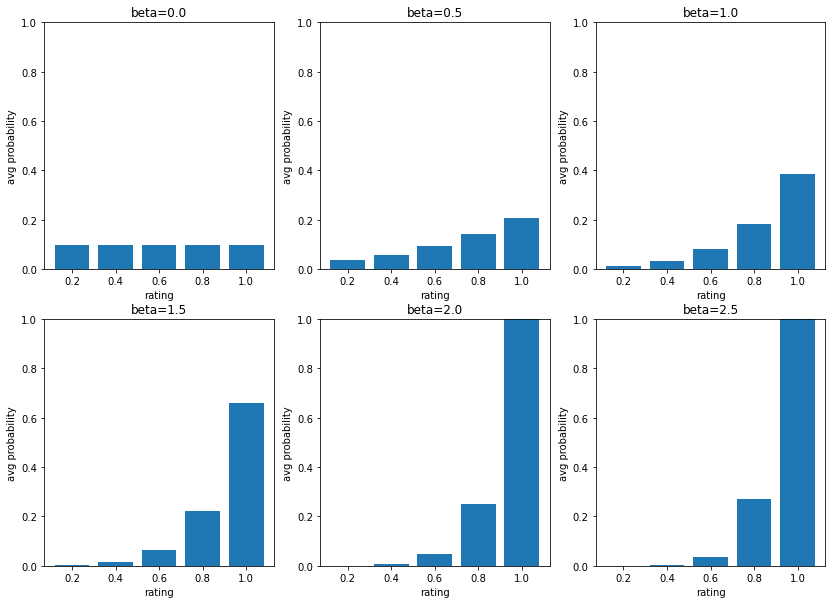

In [5]:
def average_prob(P, R):
    Ps = []
    probs = []
    for i in range(5):
        Ps.append(P.copy())
        probs.append(0)
    for i in range(5):
        Ps[i][R != (0.2 * i + 0.2)] = 0
        probs[i] = Ps[i].sum() / np.count_nonzero(Ps[i])
    return probs

fig, axs = plt.subplots(2, 3, figsize=(14, 10))
for i in range(6):
    P, R = results[i]
    probs = average_prob(P, R) 
    x_axis = ['0.2', '0.4', '0.6', '0.8', '1.0']
    axs[i // 3, i % 3].bar(x_axis, probs)
    axs[i // 3, i % 3].set(title=f'beta={beta[i]}', xlabel='rating', ylabel='avg probability', ylim=(0, 1))
fig.show()
fig.savefig('images/visualize.png', dpi=300)

# Stage 1 experiment

## ml-100k dataset


In [6]:
# beta = np.linspace(0.1, 3, 10)
# quantization = ['binary', 'onetothree', 'onetofive']
# user_knn_result_avg = {'binary': [], 'onetothree': [], 'onetofive': []}
# user_knn_result_1q = {'binary': [], 'onetothree': [], 'onetofive': []}
# user_knn_result_3q = {'binary': [], 'onetothree': [], 'onetofive': []}
# item_knn_result_avg = {'binary': [], 'onetothree': [], 'onetofive': []}
# item_knn_result_1q = {'binary': [], 'onetothree': [], 'onetofive': []}
# item_knn_result_3q = {'binary': [], 'onetothree': [], 'onetofive': []}
# svd_result_avg = {'binary': [], 'onetothree': [], 'onetofive': []}
# svd_result_1q = {'binary': [], 'onetothree': [], 'onetofive': []}
# svd_result_3q = {'binary': [], 'onetothree': [], 'onetofive': []}

# algo = KNNBasic(sim_options={'user_based': True}, verbose=False)

# for i in range(len(quantization)):

#     for j in range(len(beta)):
#         temp_results = []
#         truth = generate_ground_truth_matrix(
#         (1000, 1000), environment='ml-100k-v1')   

#         for iteration in range(10): 
#             users, items, ratings, P, R, R_no_noise = ground_truth_matrix_to_dataset(
#                 truth, quantization=quantization[i], bias='full underlying', beta=beta[j])
#             train_df = to_dataframe(ratings)

#             reader = Reader(rating_scale=(0, 1))
#             data = Dataset.load_from_df(train_df[['userID', 'itemID', 'rating']], reader)
#             trainset = data.build_full_trainset()

#             algo.fit(trainset)

#             test_df = generate_test_dataframe(R_no_noise)
#             testset = Dataset.load_from_df(test_df[['userID', 'itemID', 'rating']], reader).build_full_trainset().build_testset()
#             predictions = algo.test(testset)
#             temp_results.append(accuracy.rmse(predictions))

#         temp_results = np.array(temp_results)
#         temp_results.sort()
#         user_knn_result_avg[quantization[i]].append(temp_results.mean())
#         user_knn_result_1q[quantization[i]].append(temp_results[2])
#         user_knn_result_3q[quantization[i]].append(temp_results[7])

# algo = KNNBasic(sim_options={'user_based': False}, verbose=False)

# for i in range(len(quantization)):

#     for j in range(len(beta)):
#         temp_results = []
#         truth = generate_ground_truth_matrix(
#             (1000, 1000), environment='ml-100k-v1')

#         for iteration in range(10):
#             users, items, ratings, P, R, R_no_noise = ground_truth_matrix_to_dataset(
#                 truth, quantization=quantization[i], bias='full underlying', beta=beta[j])
#             train_df = to_dataframe(ratings)

#             reader = Reader(rating_scale=(0, 1))
#             data = Dataset.load_from_df(
#                 train_df[['userID', 'itemID', 'rating']], reader)
#             trainset = data.build_full_trainset()

#             algo.fit(trainset)

#             test_df = generate_test_dataframe(R_no_noise)
#             testset = Dataset.load_from_df(
#                 test_df[['userID', 'itemID', 'rating']], reader).build_full_trainset().build_testset()
#             predictions = algo.test(testset)
#             temp_results.append(accuracy.rmse(predictions))

#         temp_results = np.array(temp_results)
#         temp_results.sort()
#         item_knn_result_avg[quantization[i]].append(temp_results.mean())
#         item_knn_result_1q[quantization[i]].append(temp_results[2])
#         item_knn_result_3q[quantization[i]].append(temp_results[7])

# algo = SVD(verbose=False)  

# for i in range(len(quantization)):

#     for j in range(len(beta)):
#         temp_results = []
#         truth = generate_ground_truth_matrix(
#             (1000, 1000), environment='ml-100k-v1')

#         for iteration in range(10):
#             users, items, ratings, P, R, R_no_noise = ground_truth_matrix_to_dataset(
#                 truth, quantization=quantization[i], bias='full underlying', beta=beta[j])
#             train_df = to_dataframe(ratings)

#             reader = Reader(rating_scale=(0, 1))
#             data = Dataset.load_from_df(
#                 train_df[['userID', 'itemID', 'rating']], reader)
#             trainset = data.build_full_trainset()

#             algo.fit(trainset)

#             test_df = generate_test_dataframe(R_no_noise)
#             testset = Dataset.load_from_df(
#                 test_df[['userID', 'itemID', 'rating']], reader).build_full_trainset().build_testset()
#             predictions = algo.test(testset)
#             temp_results.append(accuracy.rmse(predictions))

#         temp_results = np.array(temp_results)
#         temp_results.sort()
#         svd_result_avg[quantization[i]].append(temp_results.mean())
#         svd_result_1q[quantization[i]].append(temp_results[2])
#         svd_result_3q[quantization[i]].append(temp_results[7])

In [7]:
# fig, axs = plt.subplots(1, 3, figsize=(15, 4))
# axs[0].plot(beta, user_knn_result_avg['binary'], label='2-quantization')
# axs[0].plot(beta, user_knn_result_avg['onetothree'], label='3-quantization')
# axs[0].plot(beta, user_knn_result_avg['onetofive'], label='5-quantization')
# axs[0].set(xlabel='beta', ylabel='RMSE')
# axs[0].legend(loc='upper left')

# axs[1].plot(beta, item_knn_result_avg['binary'], label='2-quantization')
# axs[1].plot(beta, item_knn_result_avg['onetothree'], label='3-quantization')
# axs[1].plot(beta, item_knn_result_avg['onetofive'], label='5-quantization')
# axs[1].set(xlabel='beta', ylabel='RMSE')
# axs[1].legend(loc='upper left')

# axs[2].plot(beta, svd_result_avg['binary'], label='2-quantization')
# axs[2].plot(beta, svd_result_avg['onetothree'], label='3-quantization')
# axs[2].plot(beta, svd_result_avg['onetofive'], label='5-quantization')
# axs[2].set(xlabel='beta', ylabel='RMSE')
# axs[2].legend(loc='upper left')
# fig.show()
# fig.savefig('images/1a.png', dpi=300)

# Synthetic dataset (`latent-static-v1`)

In [8]:
beta = np.linspace(0.1, 3, 10)
quantization = ['binary', 'onetothree', 'onetofive']
user_knn_result_avg = {'binary': [], 'onetothree': [], 'onetofive': []}
user_knn_result_1q = {'binary': [], 'onetothree': [], 'onetofive': []}
user_knn_result_3q = {'binary': [], 'onetothree': [], 'onetofive': []}
item_knn_result_avg = {'binary': [], 'onetothree': [], 'onetofive': []}
item_knn_result_1q = {'binary': [], 'onetothree': [], 'onetofive': []}
item_knn_result_3q = {'binary': [], 'onetothree': [], 'onetofive': []}
svd_result_avg = {'binary': [], 'onetothree': [], 'onetofive': []}
svd_result_1q = {'binary': [], 'onetothree': [], 'onetofive': []}
svd_result_3q = {'binary': [], 'onetothree': [], 'onetofive': []}

algo = KNNBasic(sim_options={'user_based': True}, verbose=False)

for i in range(len(quantization)):

    for j in range(len(beta)):
        temp_results = []
        truth = generate_ground_truth_matrix(
        (500, 500), environment='latent-static-v1')   

        for iteration in range(10): 
            users, items, ratings, P, R, R_no_noise = ground_truth_matrix_to_dataset(
                truth, quantization=quantization[i], bias='full underlying', beta=beta[j])
            train_df = to_dataframe(ratings)

            reader = Reader(rating_scale=(0, 1))
            data = Dataset.load_from_df(train_df[['userID', 'itemID', 'rating']], reader)
            trainset = data.build_full_trainset()

            algo.fit(trainset)

            test_df = generate_test_dataframe(R_no_noise)
            testset = Dataset.load_from_df(test_df[['userID', 'itemID', 'rating']], reader).build_full_trainset().build_testset()
            predictions = algo.test(testset)
            temp_results.append(accuracy.rmse(predictions))

        temp_results = np.array(temp_results)
        temp_results.sort()
        user_knn_result_avg[quantization[i]].append(temp_results.mean())
        user_knn_result_1q[quantization[i]].append(temp_results[2])
        user_knn_result_3q[quantization[i]].append(temp_results[7])

algo = KNNBasic(sim_options={'user_based': False}, verbose=False)

for i in range(len(quantization)):

    for j in range(len(beta)):
        temp_results = []
        truth = generate_ground_truth_matrix(
            (500, 500), environment='latent-static-v1')

        for iteration in range(10):
            users, items, ratings, P, R, R_no_noise = ground_truth_matrix_to_dataset(
                truth, quantization=quantization[i], bias='full underlying', beta=beta[j])
            train_df = to_dataframe(ratings)

            reader = Reader(rating_scale=(0, 1))
            data = Dataset.load_from_df(
                train_df[['userID', 'itemID', 'rating']], reader)
            trainset = data.build_full_trainset()

            algo.fit(trainset)

            test_df = generate_test_dataframe(R_no_noise)
            testset = Dataset.load_from_df(
                test_df[['userID', 'itemID', 'rating']], reader).build_full_trainset().build_testset()
            predictions = algo.test(testset)
            temp_results.append(accuracy.rmse(predictions))

        temp_results = np.array(temp_results)
        temp_results.sort()
        item_knn_result_avg[quantization[i]].append(temp_results.mean())
        item_knn_result_1q[quantization[i]].append(temp_results[2])
        item_knn_result_3q[quantization[i]].append(temp_results[7])

algo = SVD(verbose=False)  

for i in range(len(quantization)):

    for j in range(len(beta)):
        temp_results = []
        truth = generate_ground_truth_matrix(
            (500, 500), environment='latent-static-v1')

        for iteration in range(10):
            users, items, ratings, P, R, R_no_noise = ground_truth_matrix_to_dataset(
                truth, quantization=quantization[i], bias='full underlying', beta=beta[j])
            train_df = to_dataframe(ratings)

            reader = Reader(rating_scale=(0, 1))
            data = Dataset.load_from_df(
                train_df[['userID', 'itemID', 'rating']], reader)
            trainset = data.build_full_trainset()

            algo.fit(trainset)

            test_df = generate_test_dataframe(R_no_noise)
            testset = Dataset.load_from_df(
                test_df[['userID', 'itemID', 'rating']], reader).build_full_trainset().build_testset()
            predictions = algo.test(testset)
            temp_results.append(accuracy.rmse(predictions))

        temp_results = np.array(temp_results)
        temp_results.sort()
        svd_result_avg[quantization[i]].append(temp_results.mean())
        svd_result_1q[quantization[i]].append(temp_results[2])
        svd_result_3q[quantization[i]].append(temp_results[7])

RMSE: 0.2241
RMSE: 0.2221
RMSE: 0.2269
RMSE: 0.2245
RMSE: 0.2245
RMSE: 0.2241
RMSE: 0.2262
RMSE: 0.2214
RMSE: 0.2233
RMSE: 0.2252
RMSE: 0.2477
RMSE: 0.2482
RMSE: 0.2469
RMSE: 0.2450
RMSE: 0.2430
RMSE: 0.2475
RMSE: 0.2473
RMSE: 0.2453
RMSE: 0.2487
RMSE: 0.2492
RMSE: 0.2856
RMSE: 0.2821
RMSE: 0.2831
RMSE: 0.2856
RMSE: 0.2857
RMSE: 0.2874
RMSE: 0.2795
RMSE: 0.2851
RMSE: 0.2812
RMSE: 0.2825
RMSE: 0.3142
RMSE: 0.3104
RMSE: 0.3112
RMSE: 0.3166
RMSE: 0.3151
RMSE: 0.3207
RMSE: 0.3146
RMSE: 0.3178
RMSE: 0.3155
RMSE: 0.3119
RMSE: 0.3139
RMSE: 0.3171
RMSE: 0.3152
RMSE: 0.3171
RMSE: 0.3179
RMSE: 0.3132
RMSE: 0.3200
RMSE: 0.3150
RMSE: 0.3204
RMSE: 0.3180
RMSE: 0.3727
RMSE: 0.3722
RMSE: 0.3748
RMSE: 0.3805
RMSE: 0.3683
RMSE: 0.3778
RMSE: 0.3790
RMSE: 0.3671
RMSE: 0.3759
RMSE: 0.3741
RMSE: 0.3873
RMSE: 0.3822
RMSE: 0.3847
RMSE: 0.3855
RMSE: 0.3905
RMSE: 0.3869
RMSE: 0.3854
RMSE: 0.3852
RMSE: 0.3872
RMSE: 0.3883
RMSE: 0.3971
RMSE: 0.3978
RMSE: 0.3969
RMSE: 0.3980
RMSE: 0.3938
RMSE: 0.3936
RMSE: 0.3989

/var/folders/p2/v6y91c591nq_2q129bwd64bc0000gn/T/ipykernel_58767/3075710574.py:37: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


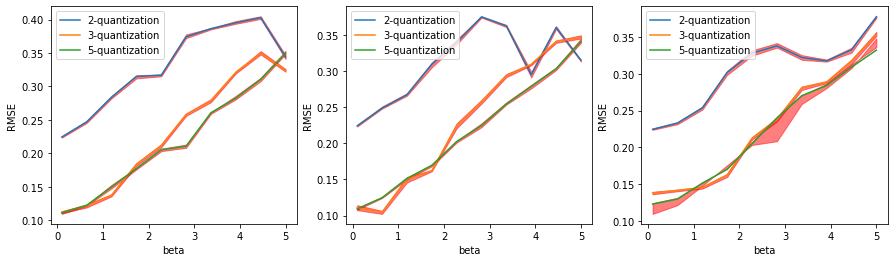

In [9]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
axs[0].plot(beta, user_knn_result_avg['binary'], label='2-quantization')
axs[0].plot(beta, user_knn_result_avg['onetothree'], label='3-quantization')
axs[0].plot(beta, user_knn_result_avg['onetofive'], label='5-quantization')
axs[0].fill_between(beta, user_knn_result_1q['binary'],
                    user_knn_result_3q['binary'], color='red', alpha=0.5)
axs[0].fill_between(beta, user_knn_result_1q['onetothree'],
                    user_knn_result_3q['onetothree'], color='red', alpha=0.5)
axs[0].fill_between(beta, user_knn_result_1q['onetofive'],
                    user_knn_result_3q['onetofive'], color='red', alpha=0.5)
axs[0].set(xlabel='beta', ylabel='RMSE')
axs[0].legend(loc='upper left')

axs[1].plot(beta, item_knn_result_avg['binary'], label='2-quantization')
axs[1].plot(beta, item_knn_result_avg['onetothree'], label='3-quantization')
axs[1].plot(beta, item_knn_result_avg['onetofive'], label='5-quantization')
axs[1].fill_between(beta, item_knn_result_1q['binary'],
                    item_knn_result_3q['binary'], color='red', alpha=0.5)
axs[1].fill_between(beta, item_knn_result_1q['onetothree'],
                    item_knn_result_3q['onetothree'], color='red', alpha=0.5)
axs[1].fill_between(beta, item_knn_result_1q['onetofive'],
                    item_knn_result_3q['onetofive'], color='red', alpha=0.5)
axs[1].set(xlabel='beta', ylabel='RMSE')
axs[1].legend(loc='upper left')

axs[2].plot(beta, svd_result_avg['binary'], label='2-quantization')
axs[2].plot(beta, svd_result_avg['onetothree'], label='3-quantization')
axs[2].plot(beta, svd_result_avg['onetofive'], label='5-quantization')
axs[2].fill_between(beta, svd_result_1q['binary'],
                    svd_result_3q['binary'], color='red', alpha=0.5)
axs[2].fill_between(beta, svd_result_1q['onetothree'],
                    svd_result_3q['onetothree'], color='red', alpha=0.5)
axs[2].fill_between(beta, user_knn_result_1q['onetofive'],
                   svd_result_3q['onetofive'], color='red', alpha=0.5)
axs[2].set(xlabel='beta', ylabel='RMSE')
axs[2].legend(loc='upper left')
fig.show()
fig.savefig('images/1b.png', dpi=300)


# Stage 2 experiment

## ml-100k dataset

In [1]:
beta = np.linspace(0, 8, 20)
p = [0] * 20
results_better = [0] * 20
results = [0] * 20

for it in range(10):
    truth = generate_ground_truth_matrix((500, 500), environment='ml-100k-v1')
    users, items, ratings, P, R, R_no_noise = ground_truth_matrix_to_dataset(
        truth, quantization='onetofive', bias='full underlying', beta=5)
    train_df = to_dataframe(ratings)    
    for i in range(20):
        p[i] = masked_nb_propensity_estimation(truth, ratings, P.shape, beta[i])
    reader = Reader(rating_scale=(0, 1))
    data = Dataset.load_from_df(
        train_df[['userID', 'itemID', 'rating']], reader)
    trainset = data.build_full_trainset()
    test_df = generate_test_dataframe(R_no_noise)
    testset = Dataset.load_from_df(
        test_df[['userID', 'itemID', 'rating']], reader).build_full_trainset().build_testset()
    for i in range(20):
        algo_better = PropensitySVD(p[i], n_epochs=2)
        algo = SVD(n_epochs=2)
        algo_better.fit(trainset)
        algo.fit(trainset)
        results_better[i] += accuracy.rmse(algo_better.test(testset))
        results[i] += accuracy.rmse(algo.test(testset))
results_better = np.array(results_better) / 10    
results = np.array(results) / 10

NameError: name 'np' is not defined

## Synthetic dataset

In [ ]:
beta = np.linspace(0, 8, 20)
p = [0] * 20
results_better_synthetic = [0] * 20
results_synthetic = [0] * 20

for it in range(10):
    truth = generate_ground_truth_matrix((500, 500), environment='latent-static-v1')
    users, items, ratings, P, R, R_no_noise = ground_truth_matrix_to_dataset(
        truth, quantization='onetofive', bias='full underlying', beta=5)
    train_df = to_dataframe(ratings)    
    for i in range(20):
        p[i] = masked_nb_propensity_estimation(truth, ratings, P.shape, beta[i])
    reader = Reader(rating_scale=(0, 1))
    data = Dataset.load_from_df(
        train_df[['userID', 'itemID', 'rating']], reader)
    trainset = data.build_full_trainset()
    test_df = generate_test_dataframe(R_no_noise)
    testset = Dataset.load_from_df(
        test_df[['userID', 'itemID', 'rating']], reader).build_full_trainset().build_testset()
    for i in range(20):
        algo_better = PropensitySVD(p[i], n_epochs=2)
        algo = SVD(n_epochs=2)
        algo_better.fit(trainset)
        algo.fit(trainset)
        results_better_synthetic[i] += accuracy.rmse(algo_better.test(testset))
        results_synthetic[i] += accuracy.rmse(algo.test(testset))
results_better_synthetic = np.array(results_better) / 10    
results_synthetic = np.array(results) / 10

/var/folders/p2/v6y91c591nq_2q129bwd64bc0000gn/T/ipykernel_58767/2309989662.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


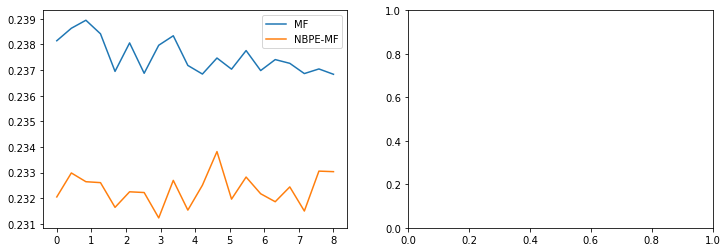

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(beta, results, label='MF')
axs[0].plot(beta, results_better, label='NBPE-MF')
axs[0].legend()
axs[0].set(xlabel='beta', ylabel='RMSE', title='ML100k Dataset')
axs[1].plot(beta, results_synthetic, label='MF')
axs[1].plot(beta, results_better_synthetic, label='NBPE-MF')
axs[1].legend()
axs[1].set(xlabel='beta', ylabel='RMSE', title='Latent Factors Dataset')
fig.show()
fig.savefig('images/2.png', dpi=300)